In [1]:
import sys, string, os, math, shutil, time
from math import fsum
import numpy as np
import scipy as sp
import scipy.stats as stats
import glob
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.optimize import shgo,minimize,curve_fit
from scipy.optimize import minimize
from scipy import optimize
from scipy import special
from scipy.fft import fft, fftfreq
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import scipy.integrate as integrate
import utils
import convol 
from scipy.signal import find_peaks
from matplotlib import cm
from scipy.integrate import trapz
from astropy.stats import sigma_clip
from PIL import Image
import csv

# Carga y lectura de espectro real


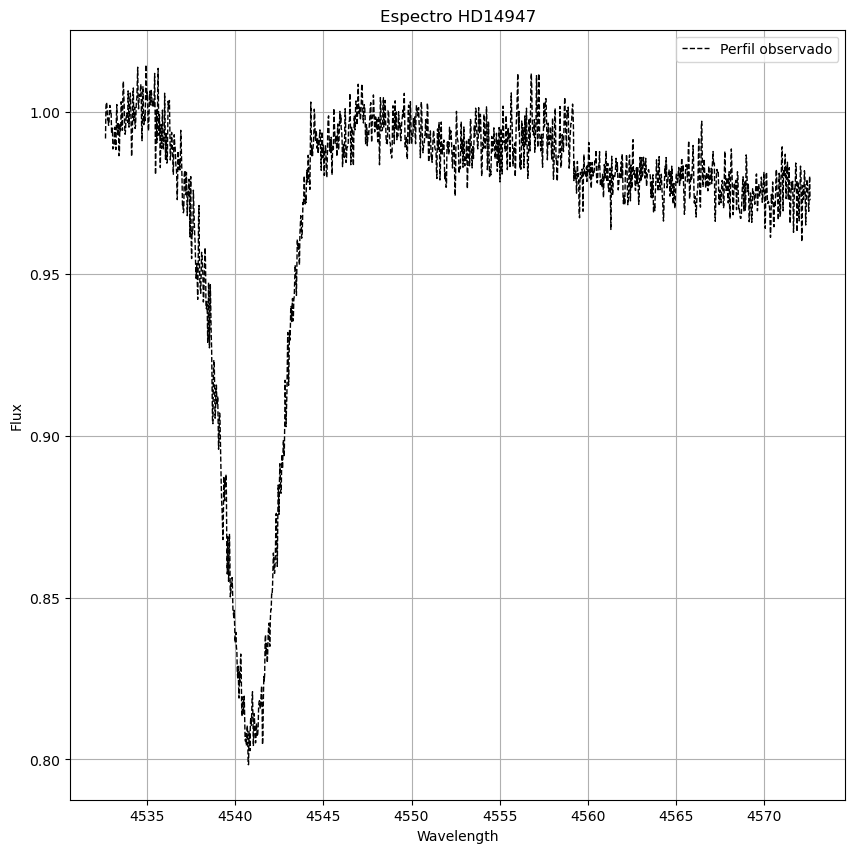

In [10]:
dirin       = "Espectros reales/"
star        = "HD14947"
w, f = utils.read_asc(dirin+star+".asc")

# Definir ruta de línea a leer
file_path ='iacob_broad_lines.dat'

line_list, lambda_list = np.genfromtxt(file_path, dtype=None, unpack=True, usecols=(0,1),encoding=None)
line = 'SiIII'

if 'line' in locals() or 'line' in globals():
    if line:
        ll = np.where(line_list == line)[0]
        lam0 = lambda_list[ll[0]]  
        xsh = 20.
        xr0 = np.array([lam0 - xsh, lam0 + xsh])
        line_lab = '_' + line
    else:
        line = ''
tt = np.where((w >= xr0[0]) & (w <= xr0[1]))
w = w[tt]
f = f[tt]
yr0 = np.min(f), np.max(f)

#---------------------------------------------------------------#
fig=plt.figure(figsize=(10,10)) 
plt.plot(w,f,c='black',label='Perfil observado',ls='--',linewidth=1.0)
plt.title('Espectro '+ star)
plt.legend()
plt.grid()
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.show()

#ruta_carpeta = 'Imágenes/'
#nombre_archivo = 'Espectro_original.png'
#fig.savefig(ruta_carpeta + nombre_archivo)

# Región inicial, normalización local, SNR, EW, y núcleo de la línea 

In [11]:
#=================== Core of the line ==========================#
xc = w[np.argmin(f)]

#=================== Initial region ============================#

#xmin = xc - 4
#xmax = xc + 4
#ii=np.nonzero((w >= xmin) & (w <= xmax))
ii = (w >= 4535) & (w <= 4565)
#ii=(w>=4525) & (w<=4565)
w0=w[ii]
f0=f[ii]

#===================== Normalization ========================#

for j in range(4):
        if j == 0:
            ii = ~np.isnan(f0)
        else:
            ii = ~sigma_clip(f0/continuum, maxiters=None,
                sigma_lower=1.4, sigma_upper=2.5, axis=-1).mask 
        c_fit = np.poly1d(np.polyfit(w0[ii], f0[ii], 1))
        continuum = c_fit(w0)
f0 = f0/ continuum
idx_min = np.argmin(f)
f_xc = f[idx_min]

#====================== Compute the SNR ===============================#

xmin_snr = 4551.62   #4551.62
xmax_snr = 4552    #4552
ii = np.where((w0>xmin_snr) & (w0<xmax_snr))
sigma=np.std(f0[ii]) 
snr=1./sigma
snr  

#================= Spectral window (wx0 , fx0) ===================================#

popt,wx,fx = utils.optimal_win(w0, f0, xc)
xmin = wx[0] - 1
xmax = wx[-1] + 1
ii=np.nonzero((w0 >= xmin) & (w0 <= xmax))
wx0=w0[ii]
fx0=f0[ii]

#====================== Calculate EW, continuum ==========================
ycont2 = utils.continuum(w,f,xc)
ycont = np.mean([fx0[0], fx0[-1]])
ew = (trapz(1 - fx0/ycont, wx0)) 
print(xc,snr,ew)

Usando k_list (+) para la elaboración de ventanas
4540.758955066878 169.46056086161002 0.7555007596163594


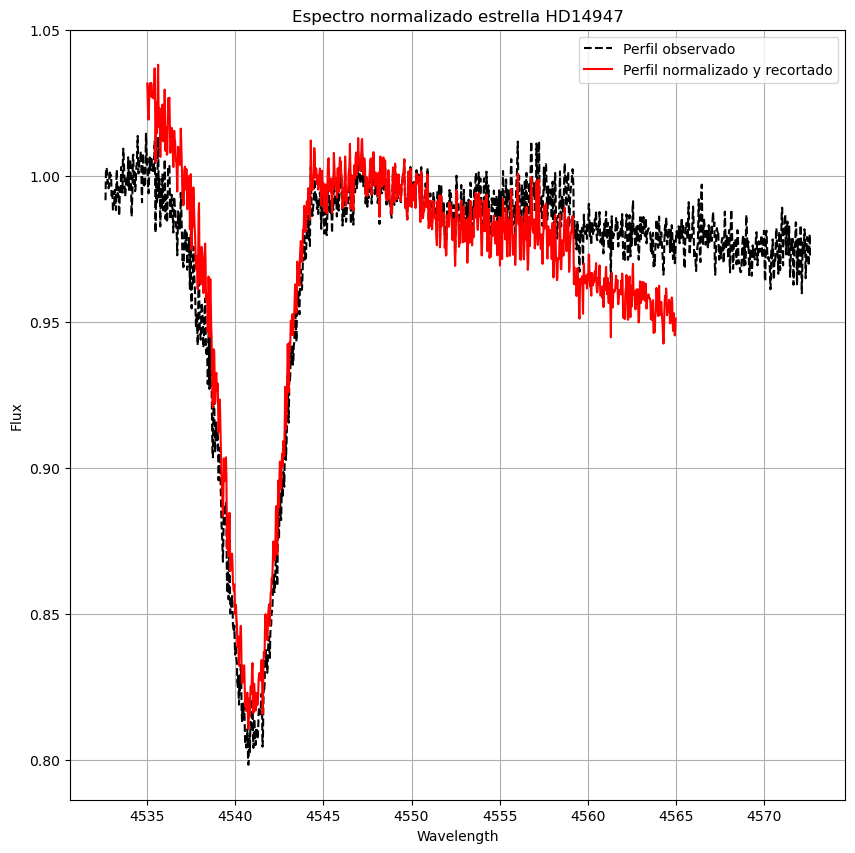

In [12]:
fig=plt.figure(figsize=(10,10)) 
plt.plot(w,f,c='black',label='Perfil observado',ls='--',linewidth=1.5)
plt.plot(w0,f0,c='red',label='Perfil normalizado y recortado',linewidth=1.5)
plt.title('Espectro normalizado estrella '+ star)
plt.legend()
plt.grid()
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.show()

#ruta_carpeta = 'Imágenes/'
#nombre_archivo = 'Espectro_normalized.png'
#fig.savefig(ruta_carpeta + nombre_archivo)

## Ajuste gaussiano a ventana espectral (wx0,fx0)

C:\Users\super\anaconda3\envs\NS_env\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


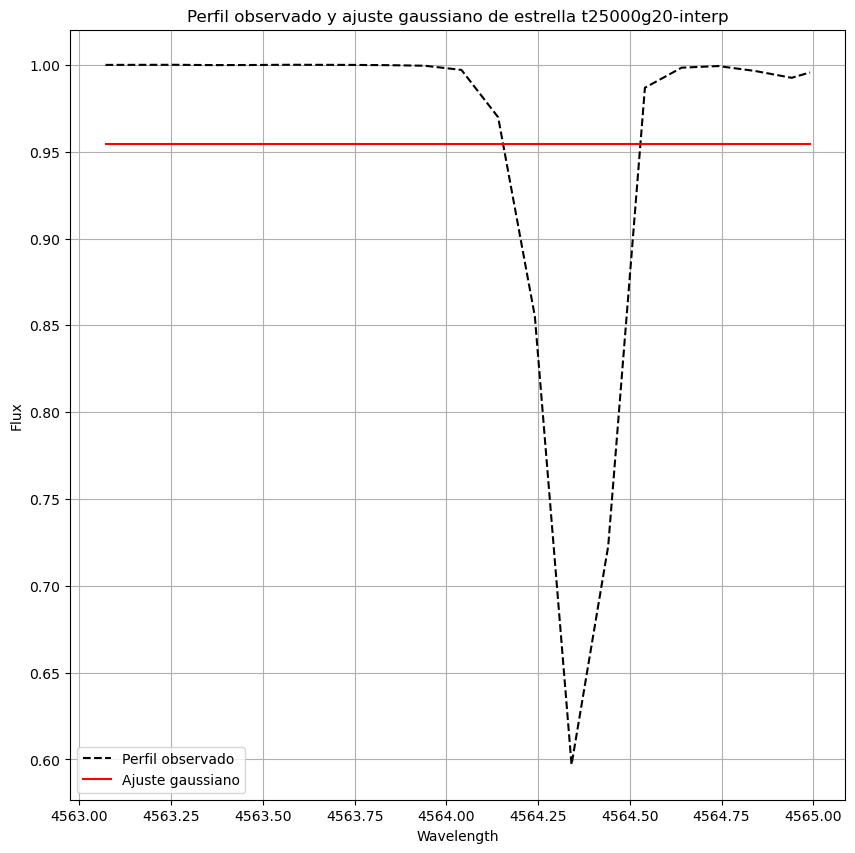

In [9]:
def gaussian(x, a, x0, sigma, c):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + c

def fit_gaussian(x, y, lambda_c):
    a_guess = np.min(y) - np.mean(y)
    x0_guess = lambda_c
    sigma_guess = np.std(x)
    c_guess = np.mean(y)
    popt, pcov = curve_fit(gaussian, x, y, p0=[a_guess, x0_guess, sigma_guess, c_guess])
    return popt

popt = fit_gaussian(wx0, fx0, xc)
x = wx0
y = gaussian(wx0,*popt)
fig=plt.figure(figsize=(10,10)) 
plt.plot(wx0,fx0,c='black',label='Perfil observado',ls='--',linewidth=1.5)
plt.plot(x,y,c='red',label='Ajuste gaussiano',linewidth=1.5)
plt.title('Perfil observado y ajuste gaussiano de estrella '+star)
plt.legend()
plt.grid()
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.show()

#ruta_carpeta = 'Imágenes/'
#nombre_archivo = 'FIT and Observer.png'
#fig.savefig(ruta_carpeta + nombre_archivo)

# Almacenar imágen en formato adecuado para primera red neuronal (SIN RUIDO)

In [14]:
#================ FORMATO ENTRADA PARA PRIMERA RED NEURONAL (SIN RUIDO) =============#

cx = w
cy = f
cx_exp = np.arange(4535, 4565, (cx[1] - cx[0]))
cy_exp = np.interp(cx_exp, cx, cy)
filename = f"Pytorch/Modelos reales/{star}_02.jpg"
plt.figure(figsize=(4, 4), dpi=100)
plt.plot(cx_exp, cy_exp, linewidth=1.5)
plt.grid(True)
plt.ylim(0.6, 1.1)
plt.savefig(filename)
plt.close()
image = Image.open(filename)
resized_image = image.resize((400, 400)).convert('L')
resized_image.save(filename, format='JPEG')


In [13]:
cx = x
cy = y
cx_exp = np.arange(4535, 4565, (cx[1] - cx[0]))
cy_exp = np.interp(cx_exp, cx, cy)
filename = f"Pytorch/Modelos reales/Ajuste gaussiano/{star}_02.jpg"
plt.figure(figsize=(4, 4), dpi=100)
plt.plot(cx_exp, cy_exp, linewidth=1.5)
plt.grid(True)
plt.ylim(0.6, 1.1)
plt.savefig(filename)
plt.close()
image = Image.open(filename)
resized_image = image.resize((400, 400)).convert('L')
resized_image.save(filename, format='JPEG')


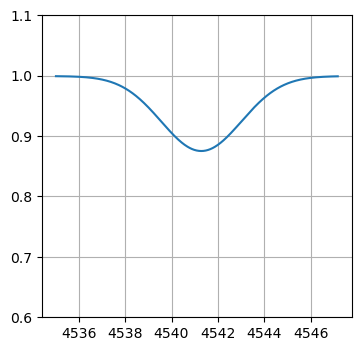

In [17]:
#================ FORMATO ENTRADA PARA SEGUNDA RED NEURONAL (CON RUIDO) =============#
    
filename = f"Pytorch/Modelos reales/{star}.jpg"
plt.figure(figsize=(4, 4), dpi=100)
plt.plot(w0,f0, linewidth=1.5)
plt.grid(True)
plt.ylim(0.6, 1.1)
plt.savefig(filename)
plt.close()
#image = Image.open(filename)
#resized_image = image.resize((400, 400)).convert('L')
#resized_image.save(filename, format='JPEG')

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(cx_exp, cy_exp, linewidth=1.5)
plt.grid(True)
plt.ylim(0.6, 1.1)
plt.savefig(filename)
plt.close()
image = Image.open(filename)
resized_image = image.resize((400, 400)).convert('L')
resized_image.save(filename, format='JPEG')

# Visualización gráfica de los 3 perfiles

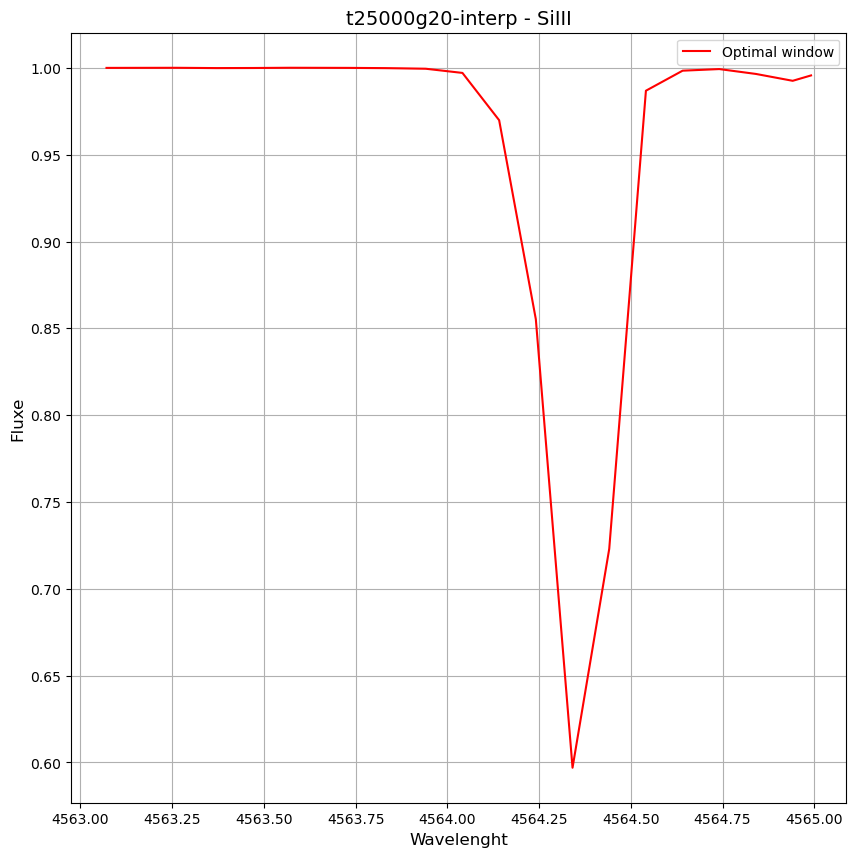

In [11]:
fig=plt.figure(figsize=(10,10)) 
#plt.plot(w0,f0,c='black',label='Observed profile',ls='--')
plt.plot(wx0,fx0,c='red',label='Optimal window')
#plt.plot(x, y , c='blue',label='Gaussian fit')
#plt.plot(wp1, fp1, c='blue',label='GOF profile')
#plt.plot(w_opt1, f_opt1, c='red',label='k=1',ls=(0, (3, 5, 1, 5)),linewidth=4)
#plt.plot(w_opt2, f_opt2, c='yellow',label='k=2',ls='dashdot',linewidth=2)
#plt.plot(w_opt3, f_opt3, c='green',label='k=3',ls='dotted',linewidth=2)
plt.xlabel('Wavelenght',fontsize=12)
plt.ylabel('Fluxe',fontsize=12)
plt.title(star+' - SiIII',fontsize=14)
plt.legend()
plt.grid()
plt.show()

# Reducción porcentual de perfil gaussiano y perfil observado 

In [10]:
def interp_arrays(x, y, length):
    if len(x)!=length:
        wx_interp=np.interp(np.linspace(0, 1, length), np.linspace(0, 1, len(x)), x)
    else:
        wx_interp=x
    if len(y)!=length:
        fx0_fit_interp=np.interp(np.linspace(0, 1, length), np.linspace(0, 1, len(y)), y)
    else:
        fx0_fit_interp=y
    return wx_interp, fx0_fit_interp

length=128
x_interp, y_interp = interp_arrays(x, y, length)
wx0_interp, fx0_interp = interp_arrays(wx0,fx0,length)

x_new, y_new = utils.reduce(x_interp, y_interp, xc, 86, 447)
wx0_new, fx0_new = utils.reduce(wx0_interp, fx0_interp, xc, 86, 447)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(x_interp, y_interp, label='Ajuste gaussiano')
axes[0].plot(x_new, y_new, label='Ajuste gaussiano reducido')
axes[0].set_xlabel('Wavelength')
axes[0].set_ylabel('Flux')
axes[0].legend()
axes[1].plot(wx0_interp, fx0_interp, label='Perfil observado')
axes[1].plot(wx0_new, fx0_new, label='Perfil observado reducido')
axes[1].set_xlabel('Wavelength')
axes[1].set_ylabel('Flux')
axes[1].legend()

plt.tight_layout()
plt.show()

ValueError: attempt to get argmin of an empty sequence

# Transformada de Fourier de los datos

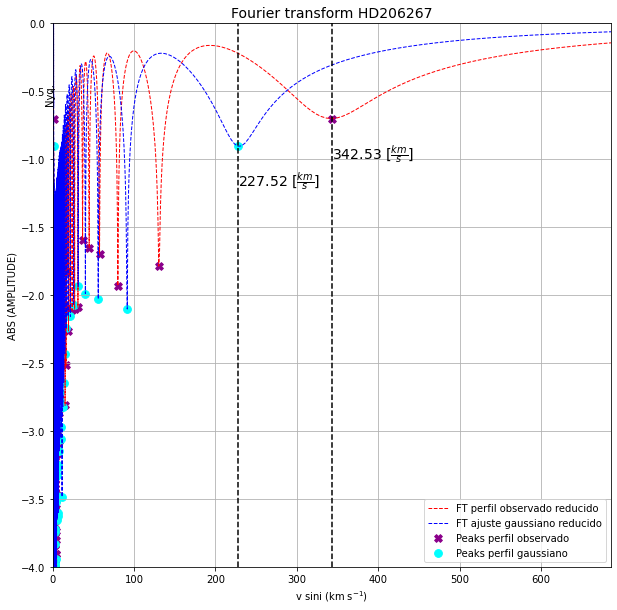

array([342.53350555, 130.36722972,  80.13398524,  57.6541544 ,
        44.90799173,  36.85487085,  31.19501568,  27.08404462,
        23.99616591,  21.51380392,  19.54050199,  17.89877949,
        16.55849174,  15.35079858,  14.36612564,  13.47932776,
        12.67721973,  11.98162468,  11.32892917,  10.77680986,
        10.26392995,   9.79764935,   9.37189312,   8.97237226,
         8.62251174,   8.29103407,   7.98409908,   7.70247301,
         7.43370587,   7.18306282,   6.95153553,   6.73187236,
         6.53543164,   6.34091063,   6.16197841,   5.98875858,
         5.82501126,   5.67366313,   5.52823063,   5.3900675 ,
         5.25864202,   5.13347305,   5.01412422,   4.90019882,
         4.79133538,   4.68720386,   4.58750231,   4.49195392,
         4.40030448,   4.31232011,   4.22778528,   4.14650102,
         4.06828337,   3.99296201,   3.92037899,   3.85038765,
         3.78285162,   3.71764392,   3.65464619,   3.59374795,
         3.53484597,   3.47784368,   3.42265062,   3.36

In [35]:
#========== FT perfil observado reducido =================================#

xfou0, yfou0, max_sigma = utils.vfft(wx0_new, fx0_new, xc)
y_0 = -1*yfou0
peaks = find_peaks(y_0)
peaks_pos = np.array(xfou0[peaks[0]])
vft = peaks_pos[0]
peaks_height = -1*y_0[peaks[0]]
vft_y = peaks_height[0]


#========== FT ajuste gaussiano reducido ================================#

xfou1, yfou1, max_sigma1 = utils.vfft(x_new, y_new, xc)
y_1 = -1*yfou1
peaks1 = find_peaks(y_1)
peaks_pos1 = np.array(xfou1[peaks1[0]])
vft1 = peaks_pos1[0]
peaks_height1 = -1*y_1[peaks1[0]]
vft_y1 = peaks_height1[0]

#=======================================================================#
plt.figure(figsize=(10,10))
plt.plot(xfou0, yfou0,color='red',lw=1,ls='--',label='FT perfil observado reducido')
plt.plot(xfou1, yfou1,color='blue',lw=1,ls='--',label='FT ajuste gaussiano reducido')
plt.axis([0,vft*2,-4,0])
plt.text(max_sigma, -0.6, 'Nyq.', fontsize=10, ha='right', va='bottom', rotation=90)
plt.text(vft, vft_y-0.3, r'{:.2f} [$\frac{{km}}{{s}}$]'.format(vft), fontsize=14)
plt.text(vft1, vft_y1-0.3, r'{:.2f} [$\frac{{km}}{{s}}$]'.format(vft1), fontsize=14)
plt.axvline(vft,color='black',linewidth=1.5,linestyle='--')
plt.axvline(vft1,color='black',linewidth=1.5,linestyle='--')
plt.scatter(peaks_pos,peaks_height,color='darkmagenta',s=60,marker='X',label='Peaks perfil observado')
plt.scatter(peaks_pos1,peaks_height1,color='cyan',s=60,marker='o',label='Peaks perfil gaussiano')
plt.xlabel('v sini (km s$^{-1}$)')
plt.ylabel('ABS (AMPLITUDE)')
plt.title('Fourier transform '+star,fontsize=14)
plt.legend()
plt.grid()
plt.show()
peaks_pos

##### 